In [2]:
import os

import numpy as np
import numpy.ma as ma

import pandas as pd
import geopandas as gpd

import sklearn

from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler

#         # model selection
from sklearn.model_selection import StratifiedKFold, train_test_split, PredefinedSplit, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline

#         # evaluation
import sklearn.metrics as metrics
from sklearn.metrics import  mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.dummy import DummyRegressor  # mean/median predictor


        # inspection
from sklearn.inspection import permutation_importance

        # results
import matplotlib.pyplot as plt

from copy import deepcopy

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Loading

In [4]:
datasets = {
    "SP": "SP_trees.shp" ,
    "CP": "CP_trees.shp"
}

#dataset = "SP"
dataset = "CP"

dirin = f"/content/drive/MyDrive/Davos_context_manuscript/data_uploaded_submitted/{dataset}_trees"
df = gpd.read_file(f'{dirin}/{datasets[dataset]}')   # 387 trees

In [5]:
# same naming
df.rename(columns = {'av_height_':'av_height_5NN', 'av_heigh_1':'av_height_10NN',
       'av_heigh_2':'av_height_15NN', 'av_heigh_3':'av_height_20NN',
        'av_heigh_4':'av_height_25NN','av_heigh_5':'av_height_30NN',
        'av_heigh_6':'av_height_35NN','av_heigh_7':'av_height_40NN',
        'av_heigh_8':'av_height_45NN', 'av_heigh_9':'av_height_50NN',
        'av_heigh10':'av_height_55NN', 'av_heigh11':'av_height_60NN',
        'av_heigh12':'av_height_65NN', 'av_heigh13':'av_height_70NN',
        'av_heigh14':'av_height_75NN'}, inplace= True)


In [6]:
for col in df.columns:
    try:
        df[col] = df[col].astype(float)
    except ValueError:
        pass
    except TypeError:
        pass

In [7]:
# in CP & SP trees, impute median where NaN in numerical cols

# SP trees
for col in df.select_dtypes(include=np.number):
    df[col].fillna(df[col].median(), inplace=True)



/tmp/ipython-input-1051178089.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


In [107]:
print(df.columns, '\n')
df['dataset_or'].unique()
print('median of DBH is: ', df[df['dataset_or']=='CP']['TREE_DBH'].median())  # 'TREE_DBH' is from inventory.

Index(['Shape_Leng', 'Shape_Area', 'LMiIndex', 'LMiZScore', 'LMiPValue',
       'ZTransform', 'SpatialLag', 'DBH_mm', 'dataset_or', 'TREE_DBH',
       'TREE_HEIGH', 'origin', 'av_height_5NN', 'av_height_10NN',
       'av_height_15NN', 'av_height_20NN', 'av_height_25NN', 'av_height_30NN',
       'av_height_35NN', 'av_height_40NN', 'av_height_45NN', 'av_height_50NN',
       'av_height_55NN', 'av_height_60NN', 'av_height_65NN', 'av_height_70NN',
       'av_height_75NN', '20SOURCE_I', '20TreeHeig', '20Shape_Le',
       '20Shape_Ar', '20LMiIndex', '20LMiZScor', '20LMiPValu', '20COType',
       '20NNeighbo', '20ZTransfo', '20SpatialL', 'n', 'distance', 'feature_x',
       'feature_y', 'nearest_x', 'nearest_y', '30SOURCE_I', '30TreeHeig',
       '30Shape_Le', '30Shape_Ar', '30LMiIndex', '30LMiZScor', '30LMiPValu',
       '30COType', '30NNeighbo', '30ZTransfo', '30SpatialL', '40SOURCE_I',
       '40TreeHeig', '40Shape_Le', '40Shape_Ar', '40LMiIndex', '40LMiZScor',
       '40LMiPValu', '40COTyp

In [8]:
#med_ref = df[df['dataset_or']=='CP']['TREE_DBH'].median()
#med_ref = med_ref_inv = 20 # CP (in cm)
med_ref = med_ref_inv = 14.5 # SP (in cm)

improvement = (5.47 - 5.29) # cm ... mm
rel_improvement = (improvement/med_ref) * 100 # in %


print('reference median is: ', med_ref, 'mm \n')
print('improvement is: ', improvement, '\n')
print('relative improvement is: ', f'{rel_improvement:.2f}', '%')

reference median is:  14.5 mm 

improvement is:  0.17999999999999972 

relative improvement is:  1.24 %


In [11]:
print(0.49/ med_ref * 100)

3.379310344827586


## Define Input (X) & Target (y)

<Axes: >

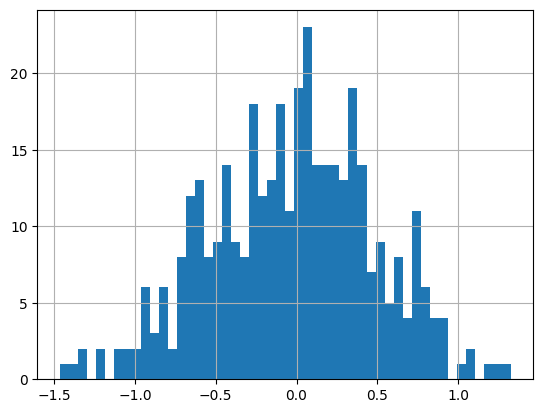

In [28]:
inventory_height = "TREE_HEIGH"
lidar_height = "TreeHeight"

a = df[inventory_height] - df[lidar_height]
a.hist(bins = 50)

In [29]:
normal_cols = ['Shape_Leng', 'Shape_Area']

In [30]:
context_cols = [
    'av_height_5NN','av_height_10NN', 'av_height_15NN', 'av_height_20NN', 'av_height_25NN',
    'av_height_30NN', 'av_height_35NN', 'av_height_40NN', 'av_height_45NN','av_height_50NN',
    'av_height_55NN', 'av_height_60NN', 'av_height_65NN', 'av_height_70NN', 'av_height_75NN',

    '20LMiIndex', '20LMiZScor', '20LMiPValu','20ZTransfo', '20SpatialL',
    '30LMiIndex', '30LMiZScor', '30LMiPValu','30ZTransfo', '30SpatialL',
    '40LMiIndex', '40LMiZScor', '40LMiPValu', '40ZTransfo', '40SpatialL',
    '50LMiIndex', '50LMiZScor', '50LMiPValu', '50ZTransfo','50SpatialL',

    'TWI_2x21', 'TWI_5x51', 'TWI_10x101'
]

In [31]:
target_col = "TREE_DBH"
if dataset == "CP" and target_col == "TREE_DBH":
    df = df.eval(f"{target_col} = {target_col} * 0.1")

 
mean DBH: 29.889394808078173
 


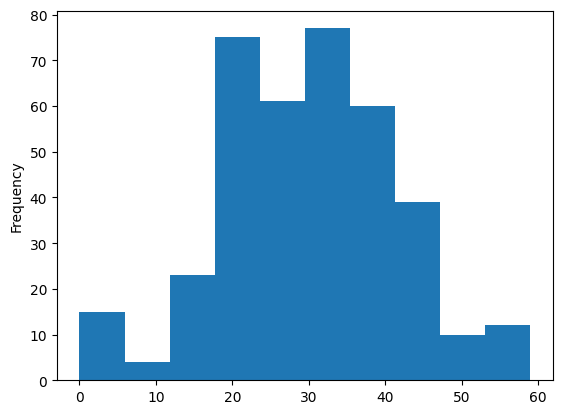

In [32]:
df[target_col].plot.hist()

print(' ')
print('mean DBH:', df[target_col].mean())
print(' ')

In [ ]:
# removal of bad labels
n = len(df)
df = df.query(f"{target_col} > 0.")
if n - len(df) != 0:
    print(f"removed {n - len(df)} zero-valued labels")

removed 3 zero-valued labels


In [ ]:
# removal of bad heights
n = len(df)
df = df.query(f"{inventory_height} > 0.")
if n - len(df) != 0:
    print(f"removed {n - len(df)} zero-valued inventory height")


n = len(df)
df = df.query(f"{lidar_height} > 0.")
if n - len(df) != 0:
    print(f"removed {n - len(df)} zero-valued LiDAR height")

removed 13 zero-valued inventory height


In [ ]:
X = df[normal_cols + context_cols + [inventory_height, lidar_height]]

In [ ]:
y = df[[target_col]]

In [ ]:
df

,Shape_Leng,Shape_Area,LMiIndex,LMiZScore,LMiPValue,ZTransform,SpatialLag,DBH_mm,dataset_or,TREE_DBH,...,50LMiPValu,50COType,50NNeighbo,50ZTransfo,50SpatialL,TWI_2x21,TWI_5x51,TWI_10x101,TreeHeight,geometry
0,27.4,24.25,0.012722,0.094700,0.480,0.924907,0.013756,404.253555,SP,40.425356,...,0.012,HH,218.0,0.749327,0.197956,3.133196,3.357633,3.990669,25.605755,POINT (565231.722 5184781.626)
1,27.4,24.25,0.012722,0.094700,0.480,0.924907,0.013756,358.098622,SP,11.936621,...,0.002,HH,215.0,0.640528,0.238315,3.726421,4.299115,3.834962,7.187945,POINT (565228.12 5184785.685)
2,27.4,24.25,0.012722,0.094700,0.480,0.924907,0.013756,432.583135,SP,43.258314,...,0.012,HH,218.0,0.749327,0.197956,3.020288,3.357633,3.990669,26.201949,POINT (565232.944 5184785.721)
3,18.8,12.38,-0.071256,-0.583817,0.280,-0.583785,0.122066,378.470455,SP,6.970987,...,0.094,None,248.0,-0.930185,0.104383,3.777375,3.919720,3.567415,8.642135,POINT (565239.874 5184784.089)
4,29.0,19.39,-0.035773,-0.295173,0.368,0.419096,-0.085364,276.292981,SP,10.567888,...,0.282,None,277.0,0.197318,-0.046125,2.971081,3.116366,3.265224,8.050685,POINT (565242.636 5184792.399)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382,31.8,17.86,0.040578,0.223768,0.430,0.487830,0.083185,347.276086,SP,25.687608,...,0.002,None,307.5,0.589419,0.178903,2.858693,2.832975,2.895473,18.922807,POINT (565190.719 5184856.144)
383,20.8,13.63,0.371541,1.419017,0.082,-0.857496,-0.433312,138.464800,SP,7.225634,...,0.060,None,249.0,-1.733639,0.124915,3.343728,3.003577,2.705298,5.340099,POINT (565201.154 5184850.671)
384,14.2,6.62,0.153563,0.973758,0.186,-0.840869,-0.182634,75.757753,SP,6.111550,...,0.002,LH,267.0,-0.950683,0.204662,3.707020,2.873606,3.053695,5.128599,POINT (565213.391 5184859.959)
385,11.8,4.39,0.320485,1.146179,0.144,-1.015201,-0.315705,63.343667,SP,6.334367,...,0.002,LH,267.0,-0.950683,0.204662,2.145402,2.873606,3.053695,6.457364,POINT (565213.462 5184856.077)


## Stratify Data by quantile bins

<Axes: ylabel='Frequency'>

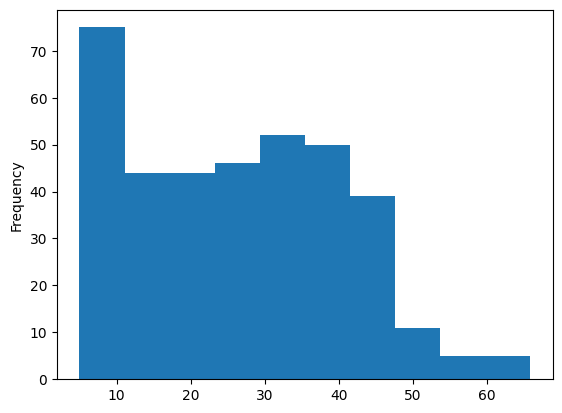

In [ ]:
y[target_col].plot.hist()

In [ ]:
# quantile bins
# Motivation: to ensure that even the tail ends of the distrbution are represented in our folds, we do a stratified sampling based on (robust) quantiles

left_edge = y[target_col].min()
right_edge = y[target_col].max()
quantiles = y[target_col].quantile([0.10, 0.25, 0.5, 0.75, 0.90]).values
bin_edges = np.concatenate([[left_edge], quantiles, [right_edge]], 0)

In [ ]:
print(bin_edges)
stratified_classes = np.zeros_like(y[target_col])
for i in range(len(bin_edges) - 1):
    min_edge = y[target_col] >= bin_edges[i]
    max_edge = y[target_col] < bin_edges[i + 1] \
        if i < (len(bin_edges) - 2) \
        else y[target_col] <= bin_edges[i + 1]
    stratified_classes += ((min_edge) & (max_edge)) * i

[ 4.99746521  7.63943727 13.46450819 26.61070648 37.33774965 43.48113045
 65.82648446]


In [ ]:
y.eval("cluster_bin = @stratified_classes", inplace=True)

/tmp/ipython-input-4157338316.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.eval("cluster_bin = @stratified_classes", inplace=True)


<Axes: xlabel='TREE_DBH', ylabel='Count'>

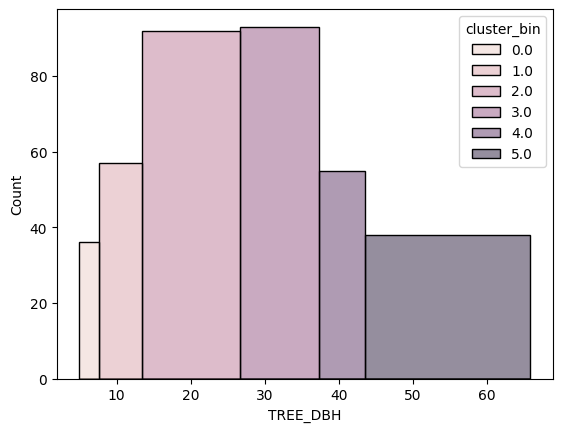

In [ ]:
import seaborn as sns
sns.histplot(data=y, x=target_col, hue="cluster_bin", bins="auto" if bin_edges is None else bin_edges)

# Hyperparameter Selection via StratifiedCV

In [ ]:
model_dict = {
    "AdaBoost": (AdaBoostRegressor, {
        "n_estimators": np.arange(10, 101, 10),
        "learning_rate": np.linspace(0.1, 1, 7),
        "loss": ("linear", "square", "exponential")
    }),
    "linear": (LinearRegression, {}),
    "Lasso": (Lasso, {"alpha": np.linspace(0.1, 1, 7)})
}


n_outer_folds = 10
n_folds = 5

In [ ]:
scoring = ["neg_mean_absolute_error", "r2", "neg_mean_absolute_percentage_error", "neg_root_mean_squared_error"]

In [ ]:
columns = [
    'split', "method", 'mae','mape', 'rmse', 'r2',
    "is_aware", "is_inventory", 'fold'
]
ab_results = pd.DataFrame(columns=columns)

def evaluate(model, X, y, plot=False):
    pred = model.predict(X)
    mse = mean_squared_error(y, pred)
    rmse = mse ** 0.5
    mae = mean_absolute_error(y, pred)
    mape = mean_absolute_percentage_error(y, pred)
    r2 = r2_score(y, pred)

    if plot:
        sns.residplot(x=pred, y=y)
        plt.show()
    return mae, mape, rmse, r2


def run(ab_results, xtrain, ytrain, xval, yval, fold_i, inner_splits, is_aware, is_inventory, debug=False):
    xcols = []
    xcols += normal_cols
    if is_inventory:
        xcols += [inventory_height]
    else:
        xcols += [lidar_height]

    if is_aware:
        xcols += context_cols

    x_train = xtrain[xcols]
    x_val = xval[xcols]

    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_val = scaler.transform(x_val)

    if debug:
        print(f"fold: {fold_i}, is_aware: {is_aware}, is_inventory: {is_inventory}")
        print(f"Cols: {xcols}")

    best_models = {}

    for model_name, (model_cls, model_params) in model_dict.items():
        #model_params = {"estimator__" + key: value for key, value in model_params.items()}

        # Do feature selection with default classifier
        feat_sel = RFECV(
            model_cls(), # would use internal scoring (e.g., coeficients or feature importance)
            # PermutationImportance(model_cls(),  scoring='r2', n_iter=5, cv=3),
            cv=inner_splits, scoring="r2", n_jobs=-1
        )

        grid = GridSearchCV(
            model_cls(), model_params, cv=inner_splits, refit="r2",
            n_jobs=-1, scoring=scoring,
        )


        pipeline = Pipeline([
            ("feature_selection", feat_sel),
            ("estimator", grid),
        ])
        pipeline.fit(x_train, ytrain[target_col])
        best_models[model_name, is_aware, is_inventory, fold_i] = pipeline

        index = pipeline["estimator"].best_index_
        cv_results = pipeline["estimator"].cv_results_
        ab_results = pd.concat([ab_results,
            pd.DataFrame([[
                "cv",
                model_name,
                -cv_results["mean_test_neg_mean_absolute_error"][index],
                -cv_results["mean_test_neg_mean_absolute_percentage_error"][index],
                -cv_results["mean_test_neg_root_mean_squared_error"][index],
                cv_results["mean_test_r2"][index],
                is_aware, is_inventory, fold_i
            ]], columns=columns)
        ])

        # training dataset performance, unimportant and most likely overfitted
        '''
        ab_results = pd.concat([ab_results,
            pd.DataFrame([[
                "train", model_name,
                *evaluate(pipeline, x_train, ytrain[target_col]),
                is_aware, is_inventory, fold_i
            ]], columns=columns)
        ])
        '''

        # validation dataset performance
        ab_results = pd.concat([ab_results,
            pd.DataFrame([[
                "test", model_name,
                *evaluate(pipeline, x_val, yval[target_col], plot=False),
                is_aware, is_inventory, fold_i
            ]], columns=columns)
        ])
    return ab_results, best_models



In [ ]:
best_models = {}

rs = np.random.RandomState(42)

# need to create stratified folds ourselves since sklearn only expects this with classifiers (outer loop)
kfold = StratifiedKFold(n_outer_folds, shuffle=True, random_state=rs)
splits = kfold._make_test_folds(X, y["cluster_bin"])
splits = PredefinedSplit(splits)
splits = splits.test_fold

# outer cross-validation loop

for fold_i in range(n_outer_folds):
    print(f"fold: {fold_i}")
    # create new training and test folds
    xtrain_ = X[splits!=fold_i]
    ytrain_ = y[splits!=fold_i]
    xval_ = X[splits==fold_i]
    yval_ = y[splits==fold_i]

    # sanity checks to see that sets are non-overlapping
    assert len(xtrain_) != len(xval_)
    assert len(xtrain_) == len(ytrain_)
    assert len(xval_) == len(yval_)
    assert all([i!=j for i in xtrain_.index for j in xval_.index])

    # need to create stratified folds ourselfs since sklearn only expects this with classifiers (inner loop)
    kfold = StratifiedKFold(n_folds, shuffle=True, random_state=rs)
    inner_splits = kfold._make_test_folds(xtrain_, ytrain_["cluster_bin"])
    inner_splits = PredefinedSplit(inner_splits)

    # with context:
    ab_results, best_model = run(
        ab_results, xtrain_, ytrain_, xval_, yval_, fold_i, inner_splits, True, True
    )
    best_models.update(best_model)
    ab_results, best_model = run(
        ab_results, xtrain_, ytrain_, xval_, yval_, fold_i, inner_splits, True, False
    ) # lidar height
    best_models.update(best_model)

    # without context
    ab_results, best_model = run(
        ab_results, xtrain_, ytrain_, xval_, yval_, fold_i, inner_splits, False, True
    )
    best_models.update(best_model)
    ab_results, best_model = run(
        ab_results, xtrain_, ytrain_, xval_, yval_, fold_i, inner_splits, False, False
    ) # lidar height
    best_models.update(best_model)





fold: 0


/tmp/ipython-input-910963314.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ab_results = pd.concat([ab_results,


fold: 1
fold: 2
fold: 3
fold: 4
fold: 5
fold: 6
fold: 7
fold: 8
fold: 9


In [ ]:
results = ab_results.groupby(["split", "method", "is_inventory", "is_aware"]).mean()[["mae", "mape", "rmse", "r2"]]
results

mae      mape      rmse        r2
split method   is_inventory is_aware                                        
cv    AdaBoost False        False     4.192877  0.184906  5.523933  0.847329
                            True      3.998453  0.189912  5.153067  0.867363
               True         False     4.012910  0.173944  5.326235  0.858066
                            True      3.821661  0.177838  4.953050  0.877356
      Lasso    False        False     4.172288  0.186933  5.443165  0.852168
                            True      4.150490  0.187467  5.420060  0.853442
               True         False     4.121478  0.180147  5.375201  0.855827
                            True      4.101065  0.180420  5.356499  0.856784
      linear   False        False     4.186395  0.189487  5.433122  0.852654
                            True      3.961538  0.188606  5.203035  0.864530
               True         False     4.139290  0.183007  5.368305  0.856147
                            True      3.933801  0.178569  5.190843  0.865129
test  AdaBoost False        False     4.259725  0.189107  5.596812  0.843165
                            True      4.006625  0.189291  5.193524  0.864615
               True         False     4.133328  0.179470  5.394798  0.853478
                            True      3.949150  0.183746  5.111648  0.869261
      Lasso    False        False     4.190314  0.189188  5.458096  0.851780
                            True      4.176885  0.188898  5.429077  0.853004
               True         False     4.149656  0.183372  5.398799  0.855102
                            True      4.131248  0.183904  5.378468  0.855873
      linear   False        False     4.194850  0.191322  5.438774  0.852713
                            True      4.109025  0.196983  5.484206  0.849960
               True         False     4.157305  0.185453  5.385859  0.855673
                            True      3.995610  0.181887  5.298454  0.859784

In [ ]:
results_std = ab_results.groupby(["split", "method", "is_inventory", "is_aware"]).std()[["mae", "mape", "rmse", "r2"]]
results_std

mae      mape      rmse        r2
split method   is_inventory is_aware                                        
cv    AdaBoost False        False     0.113647  0.006125  0.150961  0.008437
                            True      0.116430  0.007521  0.137308  0.007646
               True         False     0.138142  0.006881  0.149404  0.008223
                            True      0.104803  0.007268  0.136354  0.007095
      Lasso    False        False     0.031436  0.003692  0.078421  0.004054
                            True      0.038574  0.004146  0.085617  0.003786
               True         False     0.028920  0.003714  0.082341  0.004134
                            True      0.043937  0.004085  0.093724  0.004070
      linear   False        False     0.038404  0.001935  0.065233  0.003556
                            True      0.043790  0.005750  0.084708  0.004271
               True         False     0.036869  0.002119  0.070094  0.003614
                            True      0.078968  0.004901  0.148188  0.007659
test  AdaBoost False        False     0.373945  0.025170  0.550734  0.032356
                            True      0.356055  0.018118  0.577823  0.031388
               True         False     0.516014  0.019663  0.712719  0.037033
                            True      0.324677  0.014746  0.543957  0.027804
      Lasso    False        False     0.319992  0.014239  0.480701  0.021912
                            True      0.378655  0.019752  0.516819  0.024960
               True         False     0.330869  0.016521  0.528121  0.022452
                            True      0.371986  0.020255  0.570494  0.025768
      linear   False        False     0.344083  0.013421  0.523100  0.023767
                            True      0.435513  0.025464  0.517962  0.026459
               True         False     0.359313  0.016762  0.569051  0.024351
                            True      0.346267  0.024863  0.485292  0.026011

In [ ]:
ab_results.to_csv(f"{dataset}_results.csv", index=False)

In [ ]:
ab_results = pd.read_csv(f"{dataset}_results.csv")

In [ ]:
np.save(f"{dataset}_best_models.npy", best_models, allow_pickle=True)

In [ ]:
best_models = np.load(f"{dataset}_best_models.npy", allow_pickle=True).item()

# Looking at selected features across folds

In [ ]:
from itertools import product

columns = [
    "method", "is_aware", "is_inventory", 'fold', "feature"
]
feat_df = []

for m, a, i, f_i in product(model_dict, [True, False], [True, False], range(n_outer_folds)):
    features = best_models[(m, a, i, f_i)]["feature_selection"].get_feature_names_out()

    df = pd.DataFrame(features, columns=["feature"])
    df["method"] = m
    df["is_aware"] = a
    df["is_inventory"] = i
    df["fold"] = f_i
    feat_df.append(df)
feat_df = pd.concat(feat_df, axis=0)


<Axes: xlabel='Count', ylabel='feature'>

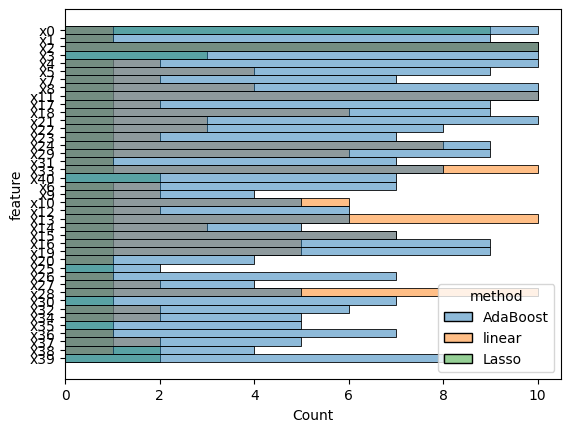

In [ ]:
sns.histplot(
    feat_df.query("is_aware == True & is_inventory == False"),
    y="feature", hue="method"
)


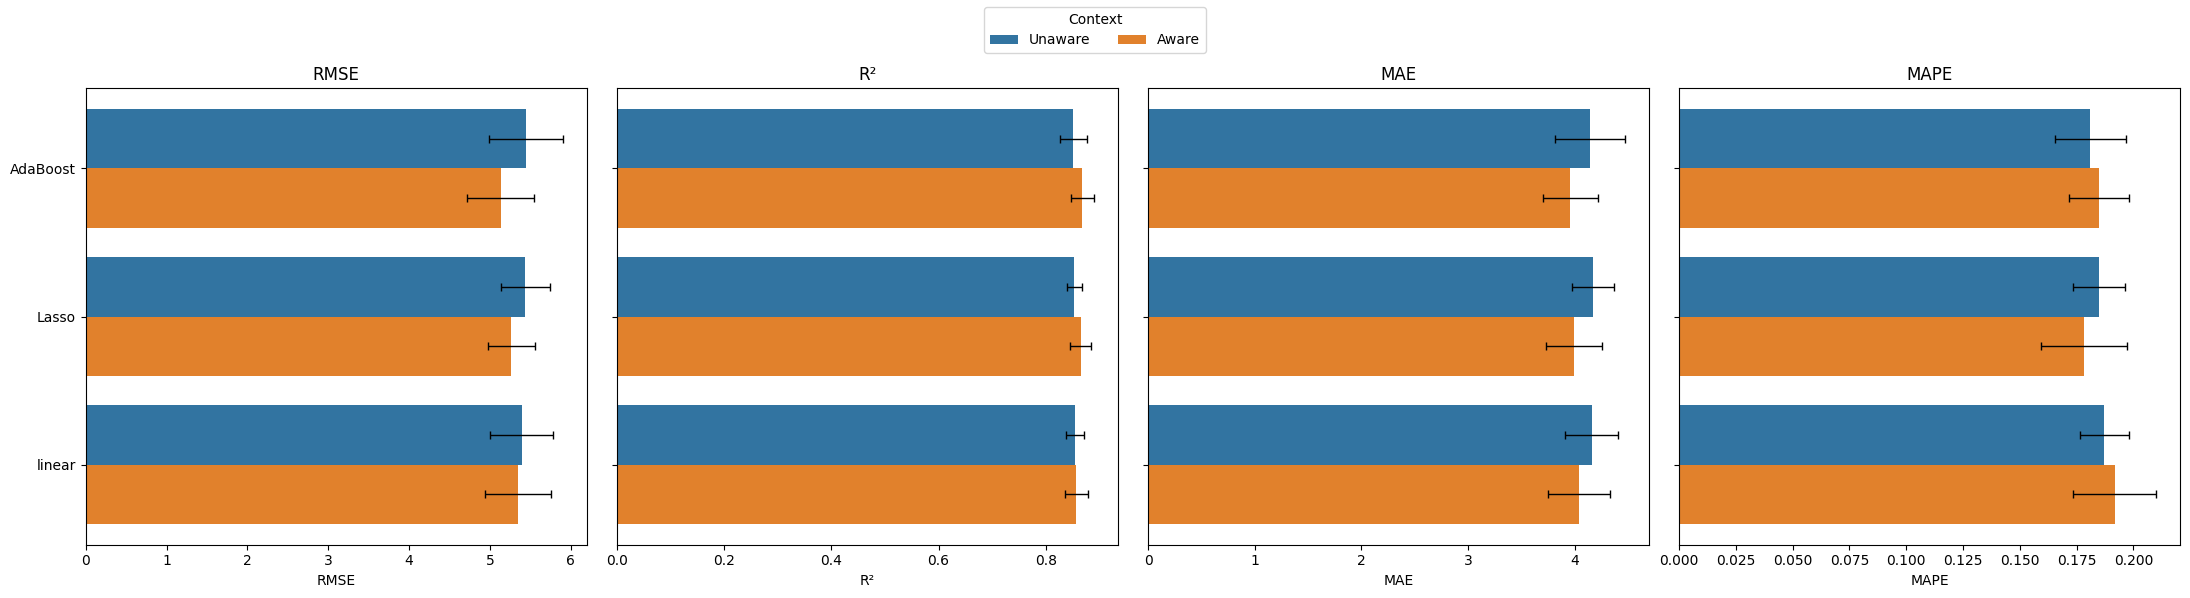

In [ ]:
# plot performance
# first: merge feat_df and ab_results
merged = feat_df.merge(
    ab_results,
    on=["method", "is_aware", "is_inventory", "fold"],
    how="left"
)

# group by mean across folds
# perf: perfect for plotting

perf = (
    merged
    .groupby(["method", "is_aware"])
    [["rmse", "r2", "mae", "mape"]]
    .mean()
    .reset_index()
)


# then, plot

'''
sns.barplot(
    data=perf,
    y="method",
    x="rmse",          # or "r2", "mae", "mape"
    hue="is_aware",
    dodge=True         # ensures side‑by‑side bars
)
plt.xlabel("RMSE")     # change label depending on metric
plt.ylabel("Regression method")
plt.title("Performance with and without context-awareness")
plt.ylim()
plt.show()
'''

perf = (
    merged
    .groupby(["method", "is_aware"])
    .agg(
        rmse_mean=("rmse", "mean"),
        rmse_std=("rmse", "std"),
        r2_mean=("r2", "mean"),
        r2_std=("r2", "std"),
        mae_mean=("mae", "mean"),
        mae_std=("mae", "std"),
        mape_mean=("mape", "mean"),
        mape_std=("mape", "std")
    )
    .reset_index()
)


import matplotlib.pyplot as plt
import seaborn as sns

metrics = ["rmse", "r2", "mae", "mape"]
labels = ["RMSE", "R²", "MAE", "MAPE"]

fig, axes = plt.subplots(1, 4, figsize=(22, 6), sharey=True)

for ax, metric, label in zip(axes, metrics, labels):
    sns.barplot(
        data=perf,
        y="method",
        x=f"{metric}_mean",
        hue="is_aware",
        dodge=True,
        ax=ax,
        errorbar=None  # we add our own error bars manually
    )

    # Add error bars manually
    for i, row in perf.iterrows():
        x = row[f"{metric}_mean"]
        err = row[f"{metric}_std"]
        y = row["method"]
        aware = row["is_aware"]

        # Compute bar position (Seaborn dodge logic)
        offset = -0.2 if not aware else 0.2
        ax.errorbar(
            x,
            ax.get_yticks()[list(perf["method"].unique()).index(y)] + offset,
            xerr=err,
            fmt="none",
            ecolor="black",
            capsize=3,
            linewidth=1
        )

    ax.set_title(label)
    ax.set_xlabel(label)
    ax.set_ylabel("")

# Single legend at the top
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, ["Unaware", "Aware"], title="Context", loc="upper center", ncol=2)
for ax in axes:
    ax.get_legend().remove()

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()





In [ ]:
feat_df.query("is_aware == True & is_inventory == False").groupby(["fold", "method"])["feature"].count()

fold  method  
0     AdaBoost    19
      Lasso        2
      linear      26
1     AdaBoost    41
      Lasso        2
      linear       9
2     AdaBoost    38
      Lasso        2
      linear       7
3     AdaBoost    24
      Lasso       41
      linear      13
4     AdaBoost    21
      Lasso        1
      linear       9
5     AdaBoost    27
      Lasso        3
      linear      19
6     AdaBoost    18
      Lasso        2
      linear      23
7     AdaBoost    41
      Lasso        2
      linear      16
8     AdaBoost    34
      Lasso        2
      linear      11
9     AdaBoost    32
      Lasso        6
      linear       6
Name: feature, dtype: int64

In [ ]:
for (m, a, i, f), g in best_models.items():
    if m=="Lasso":
        print(f"aware: {a},\tinventory: {i},\tfold: {f}, " + str(g["estimator"].best_params_))

aware: True,	inventory: True,	fold: 0, {'alpha': np.float64(0.1)}
aware: True,	inventory: False,	fold: 0, {'alpha': np.float64(0.1)}
aware: False,	inventory: True,	fold: 0, {'alpha': np.float64(0.1)}
aware: False,	inventory: False,	fold: 0, {'alpha': np.float64(0.1)}
aware: True,	inventory: True,	fold: 1, {'alpha': np.float64(0.1)}
aware: True,	inventory: False,	fold: 1, {'alpha': np.float64(0.1)}
aware: False,	inventory: True,	fold: 1, {'alpha': np.float64(0.1)}
aware: False,	inventory: False,	fold: 1, {'alpha': np.float64(0.1)}
aware: True,	inventory: True,	fold: 2, {'alpha': np.float64(0.1)}
aware: True,	inventory: False,	fold: 2, {'alpha': np.float64(0.1)}
aware: False,	inventory: True,	fold: 2, {'alpha': np.float64(0.1)}
aware: False,	inventory: False,	fold: 2, {'alpha': np.float64(0.1)}
aware: True,	inventory: True,	fold: 3, {'alpha': np.float64(0.1)}
aware: True,	inventory: False,	fold: 3, {'alpha': np.float64(0.1)}
aware: False,	inventory: True,	fold: 3, {'alpha': np.float64(0.

In [ ]:
results.to_clipboard(float_format='%.3f')

PyperclipException: 
    Pyperclip could not find a copy/paste mechanism for your system.
    For more information, please visit
    https://pyperclip.readthedocs.io/en/latest/index.html#not-implemented-error
    